Note: This was originally a take-home project for Anheuser Busch. The goal was to answer the following questions:
What are the top 3 breweries which produce the strongest beers?
Which year did beers enjoy the highest ratings?
Based on the users ratings, which factors are important among taste, aroma, appearance, and palette?
Recommend 3 beers to your friends based on this data.
Which beer style appears to be the favorite based on the reviews written by users? How do written reviews compare to overall review score for the beer style?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
import seaborn as sns


print("done")

done


# Exploratory Analysis

In [2]:
df = pd.read_csv("Beer_Data.tar.bz2", compression="bz2")

In [3]:
df.shape

(528870, 13)

In [4]:
df.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


The reviews are floats in the range of 1 to 5

In [5]:
df[["review_appearance", "review_palette", "review_overall", "review_taste", "review_aroma"]].describe()

,review_appearance,review_palette,review_overall,review_taste,review_aroma
count,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000
mean,3.864522,3.758926,3.833197,3.765993,3.817350
std,0.604010,0.685335,0.709962,0.669018,0.718903
min,0.000000,1.000000,0.000000,1.000000,1.000000
25%,3.500000,3.500000,3.500000,3.500000,3.500000
50%,4.000000,4.000000,4.000000,4.000000,4.000000
75%,4.000000,4.000000,4.500000,4.000000,4.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000


Our assumptions seem to be correct; though there are some zeros in the overall and appearance reviews. We should probably ignore those, as they look like erroneous data.

In [6]:
df = df[df["review_appearance"] > 0]
df = df[df["review_overall"] > 0]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528867 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508587 non-null  float64
 1   beer_beerId         528867 non-null  int64  
 2   beer_brewerId       528867 non-null  int64  
 3   beer_name           528867 non-null  object 
 4   beer_style          528867 non-null  object 
 5   review_appearance   528867 non-null  float64
 6   review_palette      528867 non-null  float64
 7   review_overall      528867 non-null  float64
 8   review_taste        528867 non-null  float64
 9   review_profileName  528752 non-null  object 
 10  review_aroma        528867 non-null  float64
 11  review_text         528748 non-null  object 
 12  review_time         528867 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 56.5+ MB


Looking at the output in the previous cell, we see that different columns have different non-null counts. Easiest solution to deal with it is to drop any row that has a null value by assuming that for that record we have error in collecting the data - the set is mostly complete so this shouldn't be a problem.

In [8]:
df = df.dropna()

In [9]:
df.shape

(508355, 13)

The final step before moving on to answering the questions is to deal with the problem of multiple reviews. A user can leave multiple reviews on the same beer, at different times, and this can affect our results. We keep only the highest review that a user has left for each beer ID.

In [10]:
df = df.sort_values(by="review_overall", ascending=False).drop_duplicates(subset=["review_profileName", "beer_beerId"], keep="first")

In [11]:
df.shape

(503697, 13)

## Question 1 : What are the top 3 breweries which produce the strongest beers?

In [12]:
df_q1 = df.groupby(by=["beer_brewerId"])["beer_ABV"].mean().reset_index().sort_values(by="beer_ABV", ascending=False)
# renaming the column for readability
df_q1 = df_q1.rename(columns={
    "beer_ABV": "mean_brewer_beerABV"
})

In [13]:
# rank the breweries, and output the top 3
df_q1["rank"] = df_q1["mean_brewer_beerABV"].rank(method="dense", ascending=False)
df_q1[df_q1["rank"] <= 3]

,beer_brewerId,mean_brewer_beerABV,rank
699,6513,19.228824,1.0
165,736,13.750000,2.0
1466,24215,12.466667,3.0


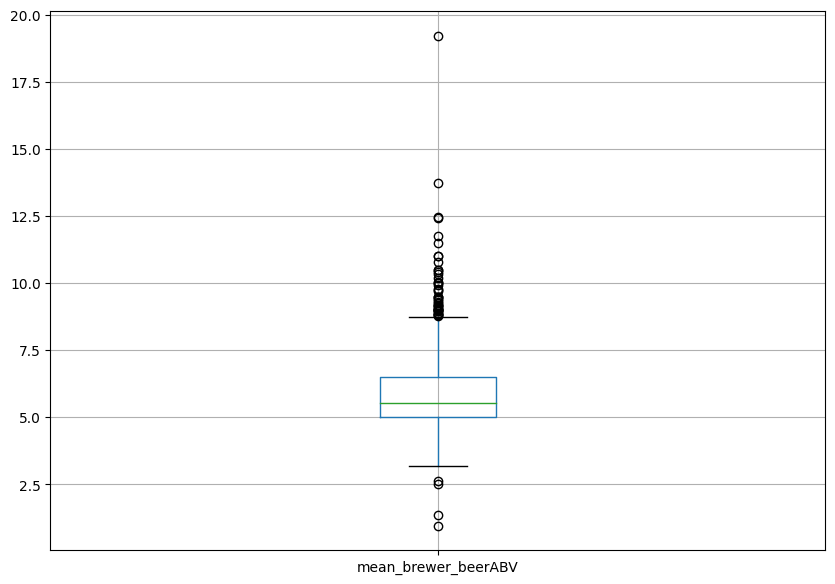

In [14]:
# plot the distribution of the beer ABV that different breweries are making
_ = df_q1.boxplot(column="mean_brewer_beerABV", figsize=(10, 7))
plt.show()

## Question 2 : Which year did beers enjoy the highest ratings?

In [15]:
# extract year from the review timestamp
df["review_year"] = pd.to_datetime(df["review_time"], unit="s").dt.year

Once we have the year we can aggregate by it and calculate the highest ratings.

As a measure of the 'highest ratings in a year' we will take the average review for that year.

In [16]:
reviews_per_year = df.groupby(by="review_year").size().to_frame("reviews_per_year").reset_index()
# print a sample
reviews_per_year.sample(n=5, random_state=42)

,review_year,reviews_per_year
9,2007,44073
11,2009,80456
0,1998,11
13,2011,107164
5,2003,16304


In [17]:
df_q2 = df.groupby(by="review_year")["review_overall"].mean().reset_index().sort_values(by="review_overall", ascending=False)
# again, renaming the column for readability
df_q2 = df_q2.rename(columns={
    "review_overall": "yearly_mean_overall_review"
})
df_q2.sample(n=5, random_state=42)

,review_year,yearly_mean_overall_review
13,2011,3.833494
9,2007,3.819697
2,2000,4.241379
6,2004,3.806850
11,2009,3.868500


In [18]:
# merging the two previous DataFrames
df_q2 = df_q2.merge(right=reviews_per_year, how="inner", on="review_year")
df_q2.sample(n=5, random_state=42)

,review_year,yearly_mean_overall_review,reviews_per_year
9,2011,3.833494,107164
11,2007,3.819697,44073
0,2000,4.241379,29
13,2004,3.806850,21038
5,2009,3.868500,80456


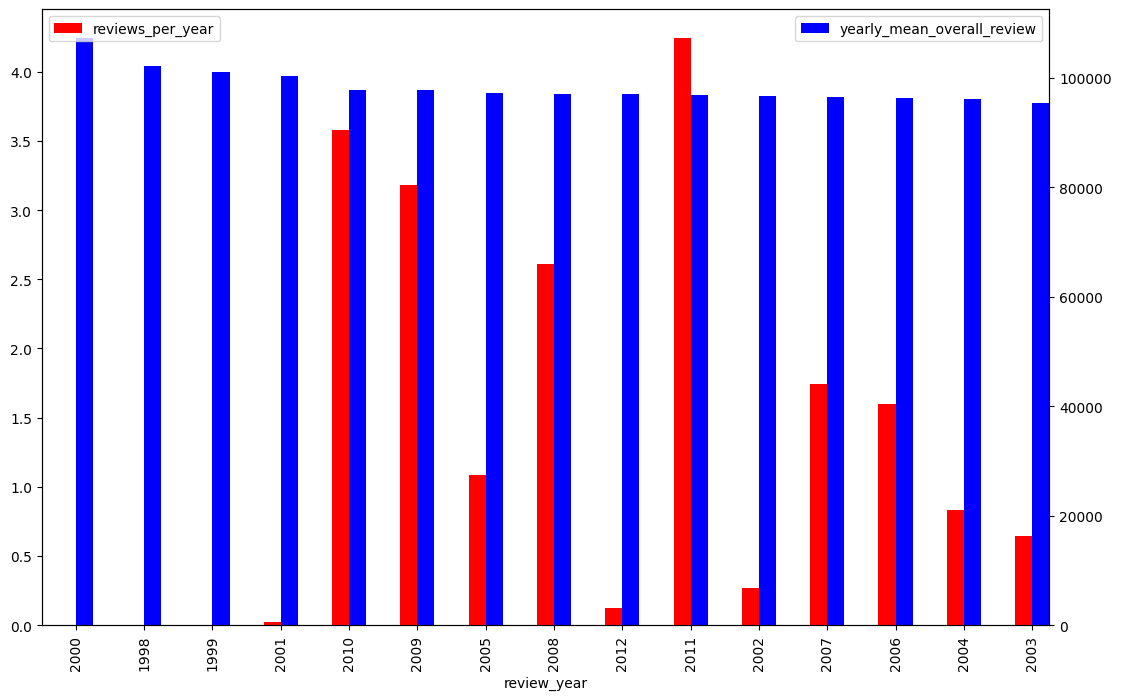

In [19]:
figure = plt.figure(figsize=(13, 8))
ax1 = figure.add_subplot(111)
ax2 = ax1.twinx()
df_q2.plot(x="review_year", y="yearly_mean_overall_review", kind="bar", color="blue", ax=ax1, width=0.25, position=0)
df_q2.plot(x="review_year", y="reviews_per_year", kind="bar", color="red", ax=ax2, width=0.25, position=1)
plt.legend(loc="upper left")
plt.show()

The year 2000 is then we got the highest overall reviews of the beers. However, the number of reviews for the top 4 years (ranked by the mean yearly review grade - the blue bars) is very small, so much so that we'd be fine by just ignoring them and marking them as "not having enough data to draw a conclusion". Therefore, the final answer to the question would be the year 2010. As an additional observation - the year 2011 has the largest number of reviews, and only slightly lower average review grade.

## Question 3 : Based on the users ratings, which factors are important among taste, aroma, appearance, and palette?

To determine the importance between the factors listed, and the users' overall ratings, we can calculate the correlation coefficient between them and use it as an importance measure.

In [20]:
# there are multiple reviews per beer so we aggregate the reviews
df_q3 = df.groupby(by="beer_beerId")[[
    "review_taste",
    "review_aroma",
    "review_appearance",
    "review_palette",
    "review_overall"
]].mean()

In [21]:
df_q3.corr()

,review_taste,review_aroma,review_appearance,review_palette,review_overall
review_taste,1.000000,0.835088,0.682127,0.756303,0.823181
review_aroma,0.835088,1.000000,0.660223,0.825980,0.883871
review_appearance,0.682127,0.660223,1.000000,0.669148,0.637575
review_palette,0.756303,0.825980,0.669148,1.000000,0.766908
review_overall,0.823181,0.883871,0.637575,0.766908,1.000000


Higher correlation = higher importance. According to the cell output, the aroma is the most important factor for the beer, having a 0.88 correlation with the overall review grade, followed closely by the taste and the palette. The appearance is the least important, but still has a high correlation coefficient.

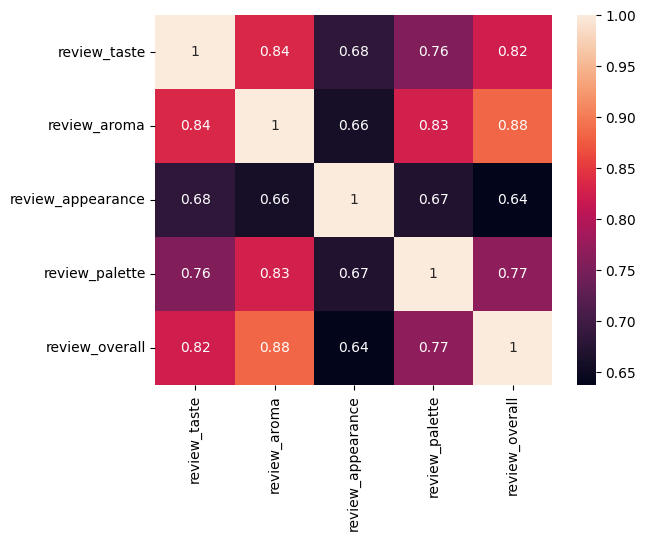

In [22]:
sns.heatmap(df_q3.corr(), annot=True)
plt.show()

## Question 4 : Recommend 3 beers to your friends based on this data.

If we were to recommend beers to our friends, based on this data-set only, we would like to recommend them the ones that are reviewed most often, and most highly.

In [23]:
df_q4 = df.groupby(by="beer_beerId")["review_overall"].agg(["count", "mean"])
# once again, renaming for readability
df_q4 = df_q4.rename(columns={
    "count": "num_reviews",
    "mean": "mean_overall_review"
})

Let's sort the beers by their average grade, and see how the top 10 perform.

In [24]:
df_q4.sort_values(by="mean_overall_review", ascending=False, inplace=True)

In [25]:
df_q4.head(n=10)

,num_reviews,mean_overall_review
beer_beerId,,
67283,1,5.0
11895,1,5.0
13222,1,5.0
62145,1,5.0
38766,1,5.0
51454,2,5.0
61988,1,5.0
72809,1,5.0
12413,1,5.0


While their grade is perfect, these beers have only been reviewed once / by a single user; and the opinions are too subjective. We would want to recommend beers that are accepted by a broader number of people, i.e., beers that are enjoyed by a larger audience.

We investigate the distribution of the number of reviews per beer, and see which number would be a proper cut-off.

In [26]:
df_q4.describe()

,num_reviews,mean_overall_review
count,14990.000000,14990.000000
mean,33.602201,3.651688
std,140.888150,0.625075
min,1.000000,1.000000
25%,1.000000,3.400000
50%,3.000000,3.750000
75%,10.000000,4.000000
max,2928.000000,5.000000


The distribution of reviews seems very skewed. Over 50% of beers have less than 3 reviews. Let's plot it and get an even better understanding.

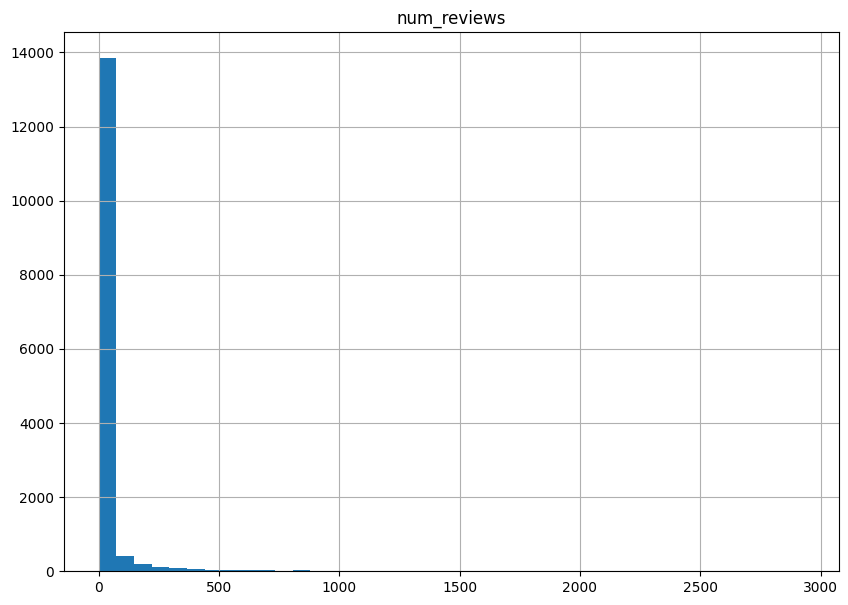

In [27]:
_ = df_q4.hist(column="num_reviews", bins=40, figsize=(10, 7))
plt.show()

As expected, a huge spike is noticed in the lowest bucket. We choose 200 reviews as a cut-off point above which we will recommend beers.

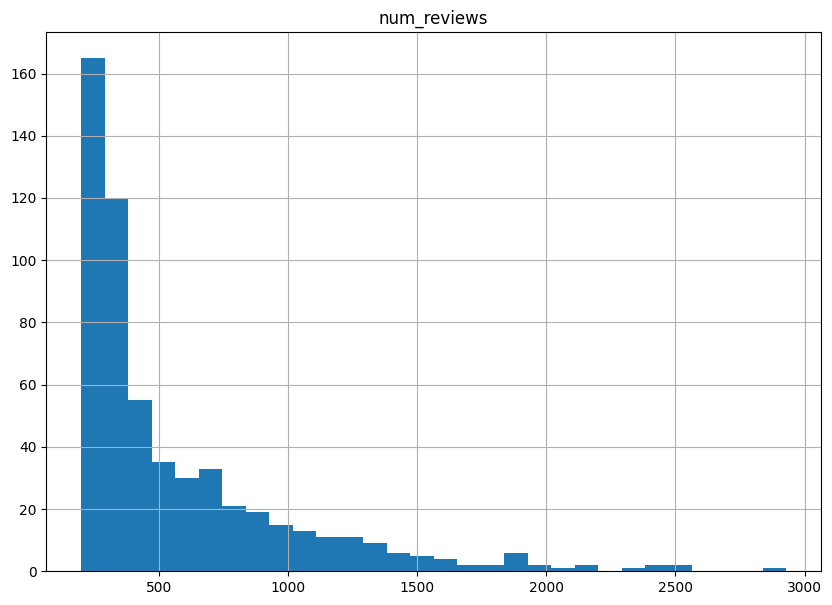

In [28]:
# plotting the distribution again
_ = df_q4[df_q4["num_reviews"] > 200].hist(column="num_reviews", bins=30, figsize=(10, 7))
plt.show()

In [29]:
# printing the head of the DataFrame, to get the top beer IDs
df_q4[df_q4["num_reviews"] > 200].head()

,num_reviews,mean_overall_review
beer_beerId,,
56082,246,4.630081
16814,443,4.623025
47658,618,4.597087
6368,627,4.491228
2899,281,4.437722


In [30]:
# we can print some top-rated beers in the previous result; to see their names and styles
# apparently, our friends will enjoy American Doubles
df[(df["beer_beerId"] == 56082) | (df["beer_beerId"] == 47658) | (df["beer_beerId"] == 16814)].drop_duplicates(
    subset="beer_beerId")

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,review_year
335037,8.0,56082,14064,Citra DIPA,American Double / Imperial IPA,4.5,5.0,5.0,5.0,OTB,5.0,I was fortunate to get two fresh bottles this ...,1322876922,2011
378616,8.0,16814,27039,Heady Topper,American Double / Imperial IPA,4.0,5.0,5.0,5.0,icepik,5.0,"A : Golden to amber color, large bubbles, some...",1325180700,2011
16698,10.6,47658,1199,Founders CBS Imperial Stout,American Double / Imperial Stout,4.5,4.5,5.0,5.0,treyrab,5.0,"After hearing so much about this beer, a sixte...",1245635836,2009


## Question 5 : Which beer style appears to be the favorite based on the reviews written by users? How do written reviews compare to overall review score for the beer style?

In [ ]:
from nltk import download
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [33]:
# this is a scored list of words and jargon that the sentiment analyser
# uses references when performing sentiment analysis

download("vader_lexicon", quiet=True)

True

In [34]:
analyser = SentimentIntensityAnalyzer()

We create a new column review_sentiment which is the compound score of the review text

In [35]:
df["review_sentiment"] = df["review_text"].apply(lambda x: analyser.polarity_scores(text=x)["compound"])

In [36]:
df.groupby(by="beer_style")["review_sentiment"].agg(func=["mean", "count"]).sort_values(by="mean", ascending=False)

,mean,count
beer_style,,
Quadrupel (Quad),0.857196,4808
Dortmunder / Export Lager,0.855261,1709
Flanders Red Ale,0.852629,2751
Roggenbier,0.850934,137
Braggot,0.850453,197
...,...,...
Happoshu,0.533456,55
American Malt Liquor,0.525378,1332
Japanese Rice Lager,0.514906,488


This output answers the first part of our question - which beer style is most favorite, it is Quadrupel (Quad) (it is furthermore confirmed by a large number of reviews, as shown in the count column). To answer the second part of the question, how the written review compares to the overall review score for the Quadrupel (Quad) style, we can calculate the correlation coefficient between the review sentiment and the overall score. All we can say is that we expect this number to be positive, not necessarily high.

Other styles have scored very close to the first one, with the difference being in the third decimal, and some beers have quite a large number of reviews.

In [37]:
df_q5 = df[df["beer_style"] == "Quadrupel (Quad)"]
df_q5[["review_sentiment", "review_overall"]].corr()

,review_sentiment,review_overall
review_sentiment,1.00000,0.25939
review_overall,0.25939,1.00000


This seems to be the case, as we see a low positive correlation at around 0.26 between the overall review score and the compound score on the review sentiment. Let's check what's happening with the other review attributes.

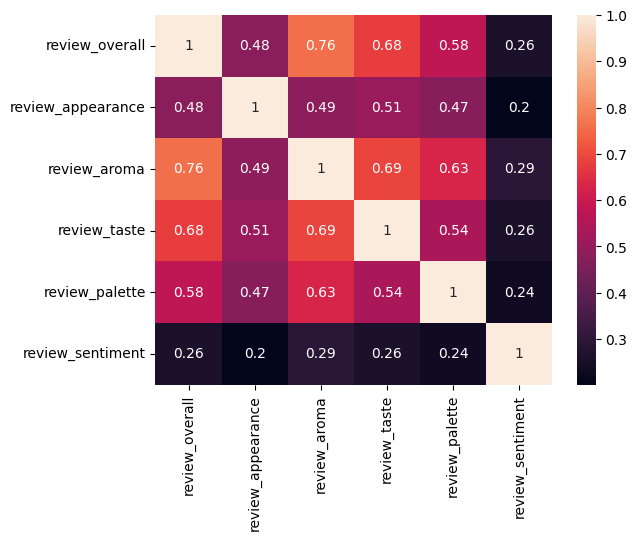

In [38]:
sns.heatmap(data=df_q5[[
    "review_overall",
    "review_appearance",
    "review_aroma",
    "review_taste",
    "review_palette",
    "review_sentiment"
]].corr(), annot=True)

plt.show()

All review attributes score similarly, at around 0.2 correlation. This is expected because a single number (the overall review) better expresses the users' opinion of the beer than the written text; that is from the viewpoint of a computer, because the NLP model is not performing at human-level. Moreover, a user could have given a high review of the beer, but leave a rather neutral comment / text. This contributes to the low correlation coefficient. The overall takeaway is that the coefficient is positive, indicating that increase in the compound score is correlated with an increase in the overall review score.